In [44]:
import pandas as pd #import packages
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [2]:
#read both dataframes and understand them
ue = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
ue.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
ue.time_stamp = pd.to_datetime(ue.time_stamp)#transform time_stamp to datetime

In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
#transform last_session and creation_time to datetime
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time, unit='s')
users.creation_time = pd.to_datetime(users.creation_time)

In [7]:
max(ue.time_stamp) #find last day in the dataset

Timestamp('2014-06-06 14:58:50')

In [8]:
ue_L7d = ue[ue.time_stamp > '2014-05-30'] #filter out to the past seven days

In [9]:
ue_L7d = pd.pivot_table(ue_L7d, values = 'visited', index='user_id', aggfunc = 'sum').reset_index() #users log count in last 7 days

In [10]:
adopted_users = ue_L7d[ue_L7d.visited >=3] #find the list of adopted users as the user IDs that have logged in more than 3 times in the past 7 days

In [11]:
df = pd.merge(users, adopted_users, how = 'left', left_on='object_id', right_on = 'user_id') #merge based on user_ids

In [12]:
df.columns

Index(['object_id', 'creation_time', 'name', 'email', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'user_id',
       'visited'],
      dtype='object')

In [13]:
df.visited = df.visited.fillna(0) #fill nas visited as 0
df = df.drop('user_id', axis = 1)

In [14]:
df['adopted'] = df.visited != 0 #create the adopted variable
df = df.drop('visited', axis = 1) #remove visited count from df

In [15]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,False


In [16]:
df.isna().sum().sort_values(ascending = False) #find NA rate

invited_by_user_id            5583
last_session_creation_time    3177
object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
adopted                          0
dtype: int64

In [17]:
df[df.last_session_creation_time.isna()].head() #understand missing values for last_session_creation_time

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaT,1,1,74,NaN,False
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,302,NaN,False
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaT,0,0,130,9270.0,False
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,175,NaN,False
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaT,0,0,211,NaN,False


In [18]:
df.invited_by_user_id = df.invited_by_user_id.fillna(0) #fill invited by missing with 0 to not match a user
df.last_session_creation_time = df.last_session_creation_time.fillna(df.creation_time) #fill missing last session with original creation (assuming no new sessions have been created)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
 10  adopted                     12000 non-null  bool          
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), o

In [20]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
object_id,12000.0,6000.5,1.0,3000.75,6000.5,9000.25,12000.0,3464.24595
creation_time,12000,2013-07-16 13:25:32.964499968,2012-05-31 00:43:27,2013-01-15 21:28:22.750000128,2013-08-05 21:35:19.500000,2014-01-28 10:20:12.249999872,2014-05-30 23:59:19,NaN
last_session_creation_time,12000,2013-08-29 02:27:35.364499968,2012-05-31 08:20:06,2013-02-21 16:22:26,2013-10-01 12:12:48,2014-04-04 00:03:08.750000128,2014-06-06 14:58:50,NaN
opted_in_to_mailing_list,12000.0,0.2495,0.0,0.0,0.0,0.0,1.0,0.432742
enabled_for_marketing_drip,12000.0,0.149333,0.0,0.0,0.0,0.0,1.0,0.356432
org_id,12000.0,141.884583,0.0,29.0,108.0,238.25,416.0,124.056723
invited_by_user_id,12000.0,3188.691333,0.0,0.0,875.0,6317.0,11999.0,3869.027693


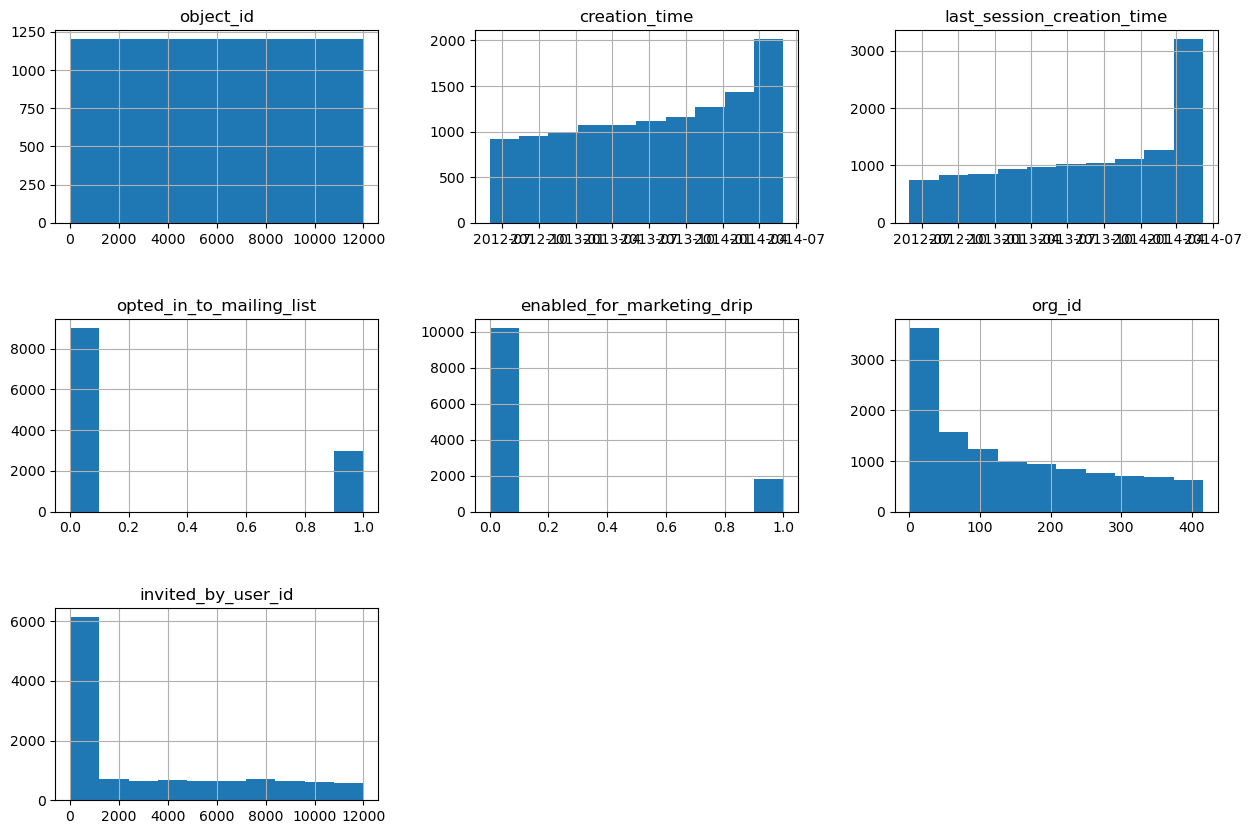

In [21]:
import matplotlib.pyplot as plt
df.hist( figsize = (15, 10))
plt.subplots_adjust(hspace=0.5);

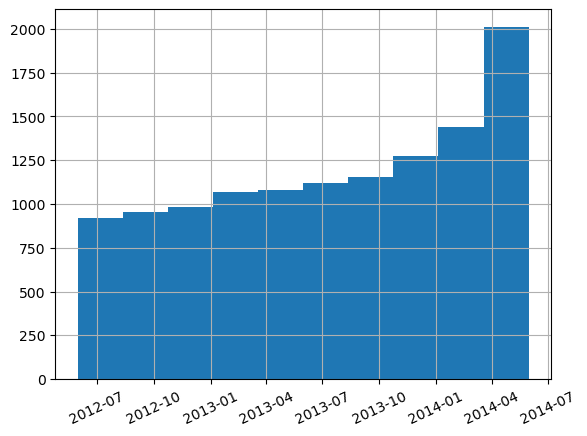

In [22]:
df.creation_time.hist()
plt.xticks(rotation = 25)
plt.show()

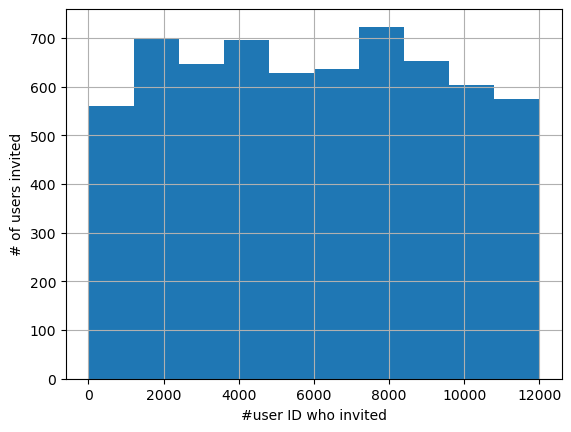

In [23]:
df[df.invited_by_user_id > 0].invited_by_user_id.hist()
plt.ylabel('# of users invited')
plt.xlabel('#user ID who invited')
plt.show()

In [24]:
df.creation_source.value_counts().sort_values(ascending=False)/len(df)

creation_source
ORG_INVITE            0.354500
GUEST_INVITE          0.180250
PERSONAL_PROJECTS     0.175917
SIGNUP                0.173917
SIGNUP_GOOGLE_AUTH    0.115417
Name: count, dtype: float64

In [25]:
df.adopted.value_counts().sort_values(ascending=False)/len(df)

adopted
False    0.962333
True     0.037667
Name: count, dtype: float64

A couple of things we have noticed here:
- There has been an increase in user creation overtime with a spike in the last trimester
- almost 25% of the people do not opt in for mailing list
- and almost 16% are not enabled for marketing drip
- Regarding the org_id, there seems to be an imbalance on the number of people from the lower org #s (under 25 ID)
- It looks like there is no significant ID member who is inviting the most users, so we will use this column as a invited by user (bool)
- It looks like most people come by ORG_invite with an even distribution of roughly 18% for every other source.
- And finally and most important, it looks like 96% of the users are not adopted users.

In [26]:
df.invited_by_user_id = df.invited_by_user_id > 0

In [27]:
df.dtypes

object_id                              int64
creation_time                 datetime64[ns]
name                                  object
email                                 object
creation_source                       object
last_session_creation_time    datetime64[ns]
opted_in_to_mailing_list               int64
enabled_for_marketing_drip             int64
org_id                                 int64
invited_by_user_id                      bool
adopted                                 bool
dtype: object

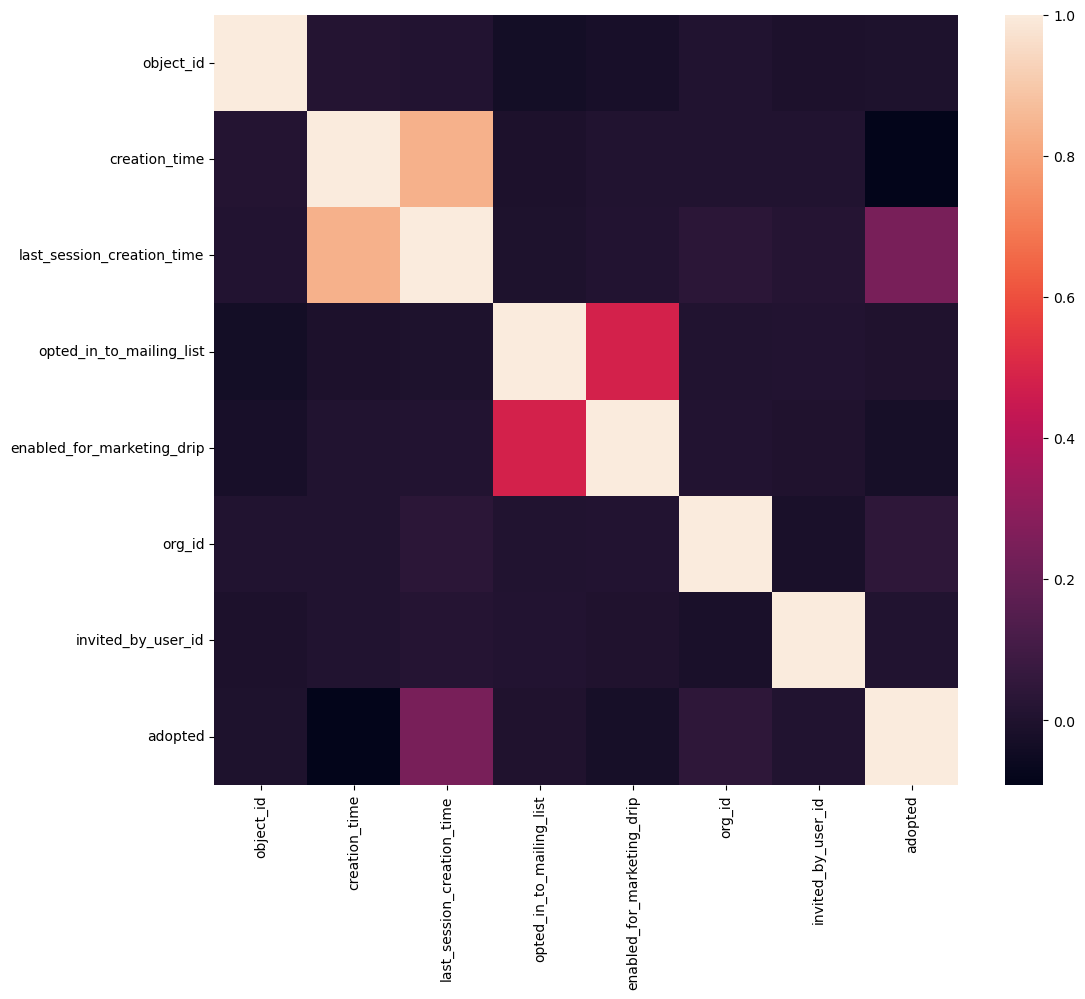

In [28]:
import seaborn as sns
# plot the correlation heatmap
plt.subplots(figsize=(12,10))
sns.heatmap(df.select_dtypes(['float64', 'int64', 'datetime64', 'bool']).corr());

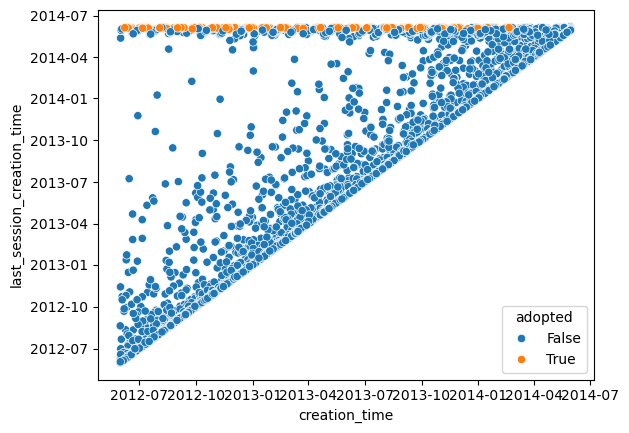

In [29]:
sns.scatterplot(x = df.creation_time, y = df.last_session_creation_time, hue = df.adopted)
plt.show()

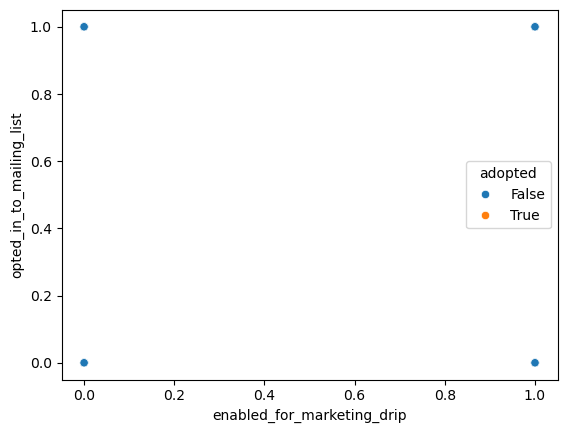

In [30]:
sns.scatterplot(x = df.enabled_for_marketing_drip, y = df.opted_in_to_mailing_list, hue = df.adopted)
plt.show()

In tersm of correlation, it looks like most variables are highly not correlated with the only cases to look out for being opted_in_to_mailing_list and enabled_for_marketing_drip which makes sense as you would need to opt in to receive it, also there is a strong correlation between creation_time, and last_session_creation_time

In [31]:
df[df.opted_in_to_mailing_list == 1].loc[:, ['opted_in_to_mailing_list', 'enabled_for_marketing_drip']].sum() #number of opted for mailing that are enabled

opted_in_to_mailing_list      2994
enabled_for_marketing_drip    1342
dtype: int64

In [32]:
df[df.opted_in_to_mailing_list == 0].loc[:, ['opted_in_to_mailing_list', 'enabled_for_marketing_drip']].sum() #number of opted for mailing that are enabled

opted_in_to_mailing_list        0
enabled_for_marketing_drip    450
dtype: int64

It looks like some users are enabled for marketing drip even if they did not opt in to mailing list, to capture this lets combine both columns into one:

In [33]:
df['marketing_material'] = (df.opted_in_to_mailing_list + df.enabled_for_marketing_drip) > 0 #create new column
df = df.drop(['opted_in_to_mailing_list', 'enabled_for_marketing_drip'], axis = 1)

In [34]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,org_id,invited_by_user_id,adopted,marketing_material
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,11,True,False,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,1,True,False,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,94,True,False,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,1,True,False,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,193,True,False,False


now lets feature engineer and get rid of some of the columns that dont add value:

In [35]:
df['days_since_creation'] = (pd.to_datetime('2014-06-06') - df.creation_time)/pd.Timedelta(days=1)
df['days_since_last_session'] = (pd.to_datetime('2014-06-06') - df.last_session_creation_time)/pd.Timedelta(days=1)
df = df.drop(['creation_time', 'last_session_creation_time'], axis = 1)

In [36]:
df.head()

,object_id,name,email,creation_source,org_id,invited_by_user_id,adopted,marketing_material,days_since_creation,days_since_last_session
0,1,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,11,True,False,True,44.837847,44.837847
1,2,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1,True,False,False,202.843704,66.843704
2,3,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,94,True,False,False,443.031343,443.031343
3,4,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1,True,False,False,380.660093,379.660093
4,5,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,193,True,False,False,504.573380,499.573380


In [38]:
df.email = df.email.str.split('@').str[1]

In [39]:
df.head()

,object_id,name,email,creation_source,org_id,invited_by_user_id,adopted,marketing_material,days_since_creation,days_since_last_session
0,1,Clausen August,yahoo.com,GUEST_INVITE,11,True,False,True,44.837847,44.837847
1,2,Poole Matthew,gustr.com,ORG_INVITE,1,True,False,False,202.843704,66.843704
2,3,Bottrill Mitchell,gustr.com,ORG_INVITE,94,True,False,False,443.031343,443.031343
3,4,Clausen Nicklas,yahoo.com,GUEST_INVITE,1,True,False,False,380.660093,379.660093
4,5,Raw Grace,yahoo.com,GUEST_INVITE,193,True,False,False,504.573380,499.573380


In [40]:
df.email.value_counts()

email
gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
                  ... 
lrabg.com            1
mrytw.com            1
ugtav.com            1
hqhll.com            1
iuxiw.com            1
Name: count, Length: 1184, dtype: int64

In [41]:
df = df.drop(['object_id', 'name', 'email'], axis = 1)

In [43]:
df.invited_by_user_id = df.invited_by_user_id.astype(int)
df.adopted = df.adopted.astype(int)
df.marketing_material = df.marketing_material.astype(int)

In [45]:
df.head()

,creation_source,org_id,invited_by_user_id,adopted,marketing_material,days_since_creation,days_since_last_session
0,GUEST_INVITE,11,1,0,1,44.837847,44.837847
1,ORG_INVITE,1,1,0,0,202.843704,66.843704
2,ORG_INVITE,94,1,0,0,443.031343,443.031343
3,GUEST_INVITE,1,1,0,0,380.660093,379.660093
4,GUEST_INVITE,193,1,0,0,504.573380,499.573380


In [60]:
dummies = pd.get_dummies(df, columns = ['creation_source', 'org_id', 'invited_by_user_id', 'marketing_material'], drop_first = True, dtype = 'int64')

In [66]:
dummies.adopted.sum()/len(dummies)

0.03766666666666667

In [50]:
1-0.0377

0.9623

In [67]:
X_train, X_test, y_train, y_test = train_test_split(dummies.drop(columns='adopted'), 
                                                    dummies.adopted, test_size=0.3, 
                                                    random_state=47, stratify = dummies.adopted)

In [68]:
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

0.03761904761904762
0.03777777777777778


In [71]:
X_train.head()

,days_since_creation,days_since_last_session,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_1,org_id_2,org_id_3,org_id_4,...,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416,invited_by_user_id_1,marketing_material_1
8970,167.618773,144.618773,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6033,7.224745,7.224745,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5625,131.122546,131.122546,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4815,294.309769,294.309769,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1411,281.058345,280.058345,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
#Now we can use the standard scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [87]:
from sklearn.linear_model import LogisticRegression
#we will use the weights to make up for the imbalance of classes in this project
weights = {0:96, 1:4} 
clf = LogisticRegression(solver = 'newton-cholesky', max_iter = 1500, class_weight = weights)
clf.fit(X_train, y_train) 
y_pred_lr = clf.predict(X_test)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:461: ConvergenceWarning: The inner solver of NewtonCholeskySolver detected a pointwise hessian with many negative values at iteration #16. It will now resort to lbfgs instead.
  warnings.warn(


In [93]:
from sklearn import metrics
#lets review the quality using the standard metrics:
y_pred = y_pred_lr
print("Model Logistic Regression")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))

Model Logistic Regression
Accuracy: 0.982
Balanced accuracy: 0.789
Precision score for "Yes":  0.919


In [90]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(5)
knn.fit(X_train,y_train)
y_pred_knn =knn.predict(X_test)

In [92]:
#lets review the quality using the standard metrics:
y_pred = y_pred_knn
print("Model KNN")
print("Accuracy: %.3F"%metrics.accuracy_score(y_test,y_pred))
print("Balanced accuracy: %.3F"%metrics.balanced_accuracy_score(y_test,y_pred))
print('Precision score for "Yes":  %.3F'%metrics.precision_score(y_test,y_pred, pos_label = 1))

Model KNN
Accuracy: 0.984
Balanced accuracy: 0.925
Precision score for "Yes":  0.750


In [96]:
import numpy as np
# Coefficients and Odds Ratios
coefficients = clf.coef_[0]
odds_ratios = np.exp(coefficients)


# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients,
    'Odds Ratio': odds_ratios
})
print("\nFeature Importance (Coefficient and Odds Ratio):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))


Feature Importance (Coefficient and Odds Ratio):
        Feature  Coefficient  Odds Ratio
145  org_id_140     3.928593   50.835421
57    org_id_52     3.783498   43.969566
246  org_id_241     3.728318   41.609042
192  org_id_187     3.521867   33.847555
24    org_id_19     3.463408   31.925597
..          ...          ...         ...
59    org_id_54    -3.837857    0.021540
65    org_id_60    -4.216837    0.014745
395  org_id_390    -4.226955    0.014597
358  org_id_353    -4.897930    0.007462
134  org_id_129    -5.027397    0.006556

[424 rows x 3 columns]


In [100]:
feature_importance.head(20)

,Feature,Coefficient,Odds Ratio
0,days_since_creation,0.007746,1.007776
1,days_since_last_session,-1.521964,0.218283
2,creation_source_ORG_INVITE,-0.313088,0.731186
3,creation_source_PERSONAL_PROJECTS,0.082099,1.085563
4,creation_source_SIGNUP,0.328202,1.388469
5,creation_source_SIGNUP_GOOGLE_AUTH,0.053836,1.055312
6,org_id_1,0.844250,2.326233
7,org_id_2,-2.870557,0.056667
8,org_id_3,2.722043,15.211361
9,org_id_4,0.413162,1.511590


In [101]:
df.head()

,creation_source,org_id,invited_by_user_id,adopted,marketing_material,days_since_creation,days_since_last_session
0,GUEST_INVITE,11,1,0,1,44.837847,44.837847
1,ORG_INVITE,1,1,0,0,202.843704,66.843704
2,ORG_INVITE,94,1,0,0,443.031343,443.031343
3,GUEST_INVITE,1,1,0,0,380.660093,379.660093
4,GUEST_INVITE,193,1,0,0,504.573380,499.573380


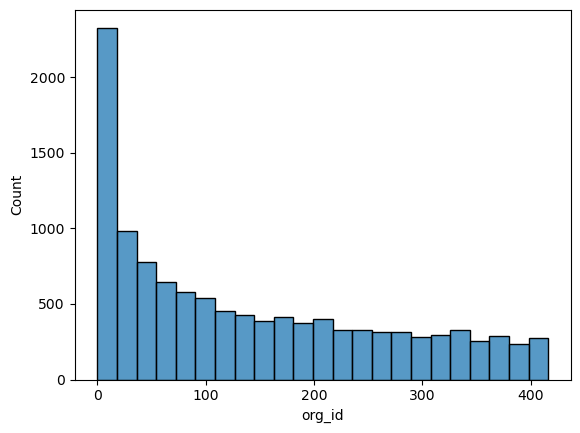

In [107]:
sns.histplot(df[df.adopted ==0], x = 'org_id')
plt.show()

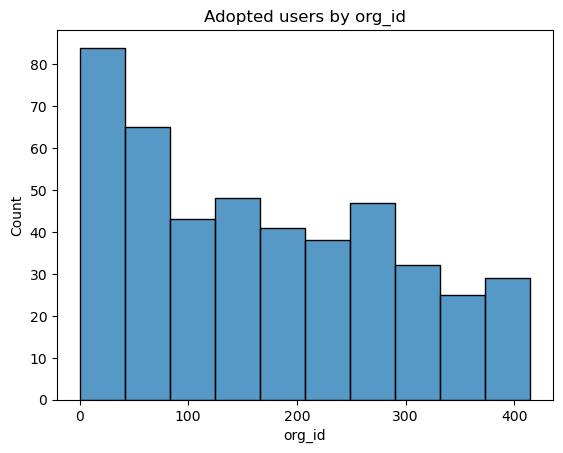

In [111]:
sns.histplot(df[df.adopted ==1], x = 'org_id').set(title='Adopted users by org_id')
plt.show()